### Import libraries and Data 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from concurrent.futures import ThreadPoolExecutor
from scipy.ndimage import distance_transform_edt
import cv2
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision.models import resnet34
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm


In [2]:
image_data = np.load('image256.npy')
mask_data=np.load('mask256.npy')

In [2]:
image_test=np.load('test256.npy')

### Data structure

In [3]:
data_image_train, data_image_val, data_mask_train, data_mask_val = train_test_split(image_data, mask_data, test_size=0.2)

In [5]:
class BuildingDataset(Dataset):
    def __init__(self, image_data, mask_data):
        self.images = image_data
        self.masks = mask_data

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = self.images[idx]
        mask = self.masks[idx]

        image_tensor = torch.tensor(image, dtype=torch.float32)
        mask_tensor = torch.tensor(mask, dtype=torch.float32)

        return (
            image_tensor,
            mask_tensor,
        )

In [6]:
train_dataset = BuildingDataset(data_image_train, data_mask_train)
val_dataset = BuildingDataset(data_image_val,data_mask_val)

trainloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=16, shuffle=False)


### Implementing Model 

#### Model 

In [3]:
class Unet_buil_seg(nn.Module):
    def __init__(self, in_channels=3, out_channels_seg=1):
        super(Unet_buil_seg, self).__init__()
        
        base_model = resnet34(pretrained=True)
        self.encoder_layers = list(base_model.children())
        self.encoder1 = nn.Sequential(*self.encoder_layers[:3])  
        self.encoder2 = nn.Sequential(*self.encoder_layers[3:5])  
        self.encoder3 = self.encoder_layers[5]  
        self.encoder4 = self.encoder_layers[6]  
        self.encoder5 = self.encoder_layers[7]  

        self.bottleneck = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.up4 = self._upsample_block(512, 256)
        self.up3 = self._upsample_block(256, 128)
        self.up2 = self._upsample_block(128, 64)
        self.up1 = self._upsample_block(64, 64)

        self.segmentation_head = nn.Conv2d(64, out_channels_seg, kernel_size=1)

    def _upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # === Encoder ===
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)

        # Bottleneck
        bottleneck_output = self.bottleneck(e5)

        # === Decoder ===
        d4 = self.up4(bottleneck_output) + e4  
        d3 = self.up3(d4) + e3
        d2 = self.up2(d3) + e2
        d1 = self.up1(d2) + e1

        # === Segmentation Map ===
        seg_map = self.segmentation_head(d1)
        seg_map = F.interpolate(seg_map, size=x.shape[2:], mode='bilinear', align_corners=False)
        

        return seg_map


#### Loss and Metrics 

In [8]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, preds, targets, smooth=1.0):
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + smooth)
        return 1 - dice.mean()

def bce_dice_loss(preds, targets):
    dice_loss = DiceLoss()(preds, targets)
    return  dice_loss

def compute_iou(preds, targets, threshold=0.5):
    preds = torch.sigmoid(preds) > threshold
    intersection = (preds & targets.bool()).float().sum(dim=(2, 3))
    union = (preds | targets.bool()).float().sum(dim=(2, 3))
    iou = (intersection / (union + 1e-6)).mean()  
    return iou.item()


#### building train and val functions 

In [12]:
def train_one_epoch(model, trainloader, optimizer, device):
    model.train()
    running_loss = 0.0
    total_iou = 0.0

    for images, masks in tqdm(trainloader, desc="Training", leave=False):
        images, masks= images.permute(0,3,1,2).to(device),masks.unsqueeze(1).to(device)

        optimizer.zero_grad()
        seg_preds = model(images)
        
        loss_seg = bce_dice_loss(seg_preds, masks)       

        loss =  loss_seg

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_iou += compute_iou(seg_preds, masks)

    return running_loss / len(trainloader), total_iou / len(trainloader)

def validate(model, valloader, device):
    model.eval()
    running_loss = 0.0
    total_iou = 0.0

    with torch.no_grad():
        for images, masks in tqdm(valloader, desc="Validation", leave=False):
            images, masks =  images.permute(0,3,1,2).to(device),masks.unsqueeze(1).to(device),

            seg_preds = model(images)

            loss_seg = bce_dice_loss(seg_preds, masks)

            loss =   loss_seg

            running_loss += loss.item()
            total_iou += compute_iou(seg_preds, masks)

    return running_loss / len(valloader), total_iou / len(valloader)

def train_model(model, trainloader, valloader, epochs, lr, device):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_iou": [],
        "val_iou": []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        train_loss, train_iou = train_one_epoch(model, trainloader, optimizer, device)
        print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")

        val_loss, val_iou = validate(model, valloader, device)
        print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_iou"].append(train_iou)
        history["val_iou"].append(val_iou)

    plot_metrics(history)

    return history

def plot_metrics(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Evolution")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_iou"], label="Train IoU", marker="o")
    plt.plot(epochs, history["val_iou"], label="Val IoU", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.title("IoU Evolution")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


#### Train and evaluation

c:\Users\anskr\anaconda3\envs\bdt\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\anskr\anaconda3\envs\bdt\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10


Train Loss: 0.6449, Train IoU: 0.2633


Val Loss: 0.5157, Val IoU: 0.3852

Epoch 2/10


Train Loss: 0.3375, Train IoU: 0.5409


Val Loss: 0.2752, Val IoU: 0.6082

Epoch 3/10


Train Loss: 0.2459, Train IoU: 0.6373


Val Loss: 0.2476, Val IoU: 0.6383

Epoch 4/10


Train Loss: 0.2168, Train IoU: 0.6705


Val Loss: 0.2265, Val IoU: 0.6603

Epoch 5/10


Train Loss: 0.1981, Train IoU: 0.6921


Val Loss: 0.2158, Val IoU: 0.6735

Epoch 6/10


Train Loss: 0.1851, Train IoU: 0.7076


Val Loss: 0.2050, Val IoU: 0.6855

Epoch 7/10


Train Loss: 0.1734, Train IoU: 0.7220


Val Loss: 0.1993, Val IoU: 0.6936

Epoch 8/10


Train Loss: 0.1662, Train IoU: 0.7314


Val Loss: 0.1936, Val IoU: 0.6992

Epoch 9/10


Train Loss: 0.1601, Train IoU: 0.7391


Val Loss: 0.1917, Val IoU: 0.7016

Epoch 10/10


Train Loss: 0.1549, Train IoU: 0.7456


Val Loss: 0.1874, Val IoU: 0.7066


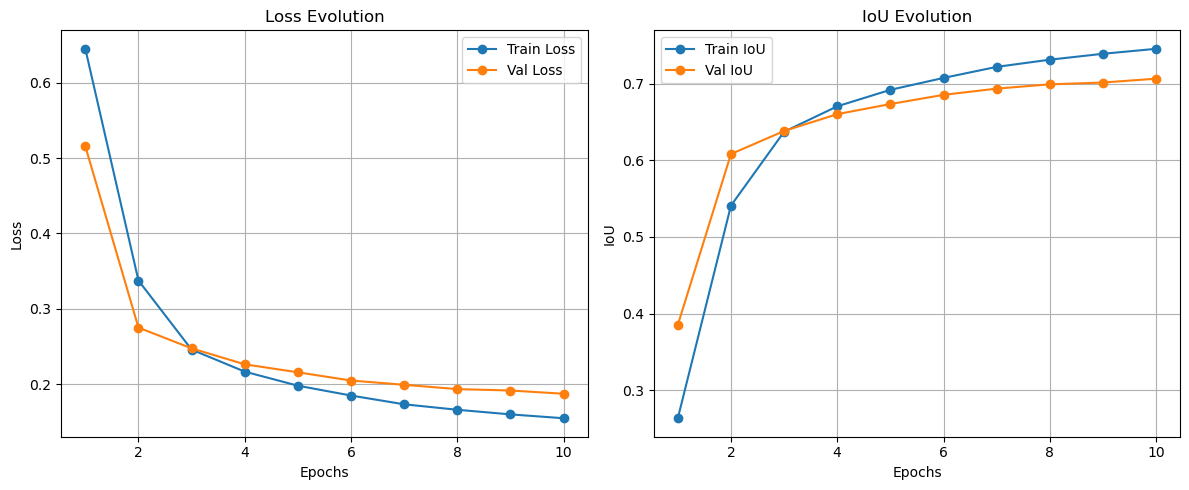

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet_buil_seg(in_channels=3, out_channels_seg=1)

epochs = 10
lr = 5e-5

history=train_model(model, trainloader, valloader, epochs, lr, device)


In [15]:
torch.save(model.state_dict(), "Unet_polyg.pth")

### Prediction Polygons

In [4]:
def preticted_polygone(model, image, model_path):

    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Convertir l'image en tenseur PyTorch
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
    
    # Passer l'image dans le modèle
    segmentation_pred = model(image_tensor)
    
    # Convertir les prédictions en tableaux NumPy
    segmentation_pred = (segmentation_pred.squeeze().detach().cpu().numpy()>0.4).astype(np.uint8)
    
    contours, _ = cv2.findContours(segmentation_pred.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Créer une nouvelle image pour dessiner les polygones
    height, width = segmentation_pred.shape
    polygon_map = np.zeros((height, width, 3), dtype=np.uint8)

    # Extraire et dessiner les polygones
    for contour in contours:
# Paramètre pour simplifier les polygones
        approx = cv2.approxPolyDP(contour, 2 ,True)
        cv2.fillPoly(polygon_map, [approx], (0, 255, 0))  # Remplir les polygones en vert



    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)

    plt.imshow(image)
    plt.imshow(cv2.cvtColor(polygon_map, cv2.COLOR_BGR2RGB), alpha=0.3)

    plt.subplot(1,2,2)
    plt.imshow(image)
    plt.show()

    return


C:\Users\anskr\AppData\Local\Temp\ipykernel_39972\3310000499.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


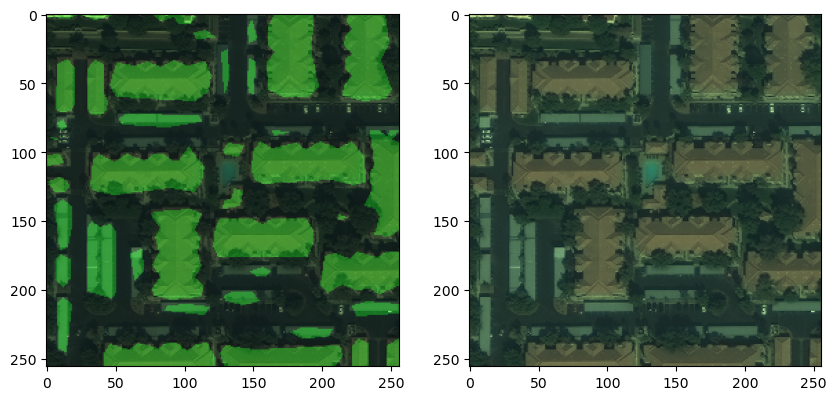

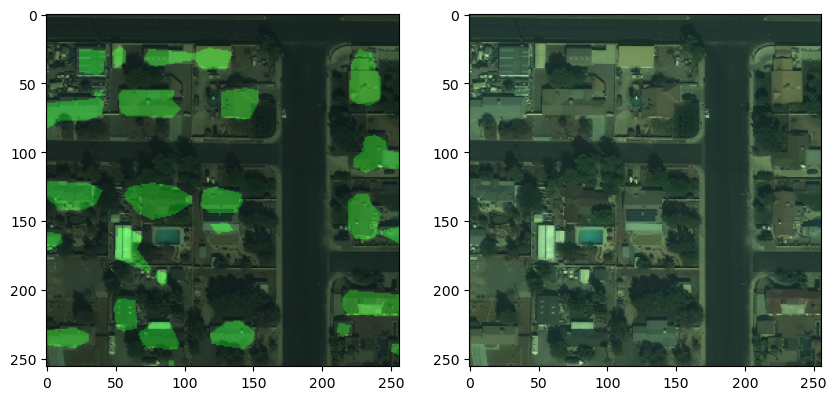

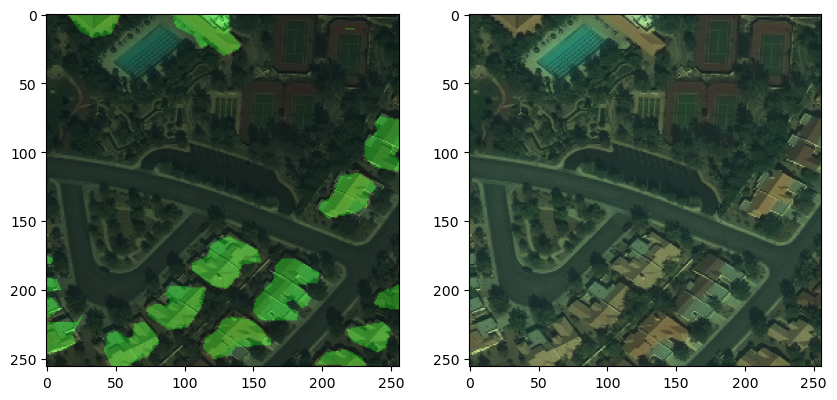

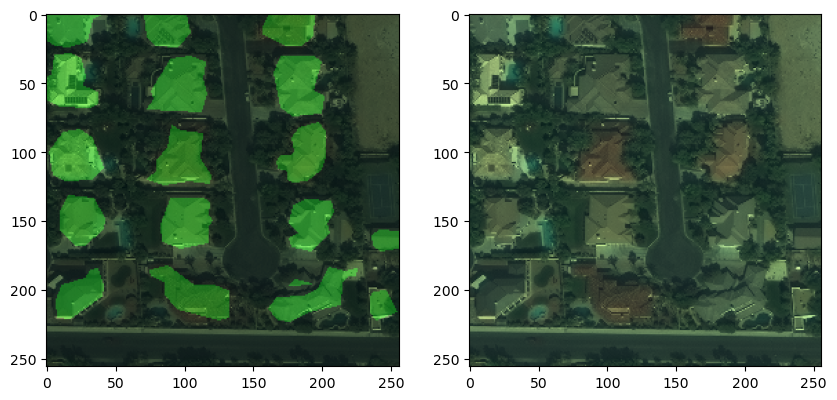

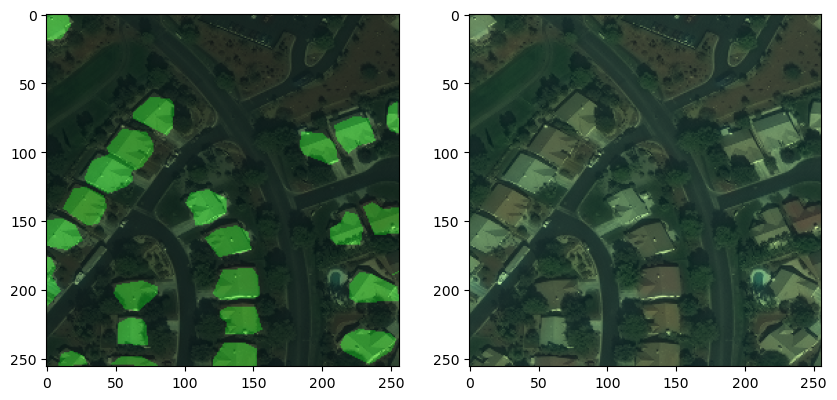

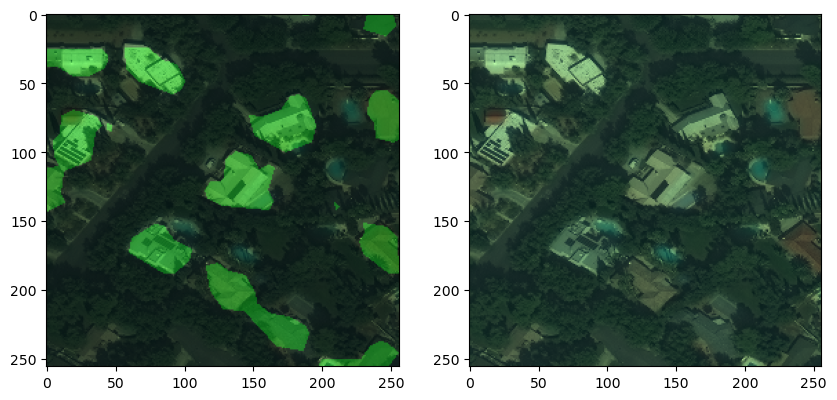

In [6]:
for i in range (2):
    preticted_polygone(Unet_buil_seg(),image_test[42+i],"Unet_polyg.pth")
    preticted_polygone(Unet_buil_seg(),image_test[569+i],"Unet_polyg.pth")
    preticted_polygone(Unet_buil_seg(),image_test[910+i],"Unet_polyg.pth")

